In [1]:
import notebook_setup
from notebook_setup import MODELS_DIR

import numpy as np
import torch 
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from gpmdm import GPMDM, GPMDM_PF
from dataset_utils.mocap_labels import WALK_TRIALS_TRAIN, WALK_TRIALS_TEST, RUN_TRIALS_TRAIN, RUN_TRIALS_TEST
import dataset_utils.select_joints as select_joints

In [2]:
model_path = MODELS_DIR / 'gpmdm' / 'gpmdm_4d_30fps.pth'
gpdm = GPMDM.load(model_path)


Model and hyperparameters correctly loaded


In [3]:
reduced_columns = WALK_TRIALS_TEST[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)
DOFs = len(reduced_columns)
print(f"Number of DOFs: {DOFs}")


Number of DOFs: 35


In [4]:
DOWNSAMPLE = 4

TEST_TRIALS = RUN_TRIALS_TEST + WALK_TRIALS_TEST
TRUTH_LABELS = [1] * len(RUN_TRIALS_TEST) + [0] * len(WALK_TRIALS_TEST)

reduced_columns = TEST_TRIALS[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)
DOFs = len(reduced_columns)
print(f"Number of DOFs: {DOFs}")

Number of DOFs: 35


In [5]:
# Markov Transition Matrix between classes
markov_transition_matrix = torch.tensor(
    [[0.9, 0.1], 
     [0.1, 0.9]])

# Build a gpdm_pf model
gpdm_pf = GPMDM_PF(gpdm, 
                   markov_switching_model=markov_transition_matrix,
                   num_particles=100)

In [6]:
trial_number = 5
test_trial = TEST_TRIALS[trial_number]
test_trial_label = TRUTH_LABELS[trial_number]
data_arr = test_trial.as_dataframe()[reduced_columns].to_numpy(dtype=np.float32)[::DOWNSAMPLE, :]

In [7]:
gpdm_pf.reset()
correct = 0
total = 0

predicted_latent_states = torch.zeros((len(data_arr), gpdm_pf.latent_dim))

# Run the filter bank on the trial
for data in data_arr:
    gpdm_pf.update(data)
    predicted_label = gpdm_pf.get_most_likely_class()
    latest_probs = gpdm_pf.class_probabilities()
    p_walk = latest_probs[0]
    p_run = latest_probs[1]
    predicted_latent_states[total] = gpdm_pf.current_state_mean()

    if predicted_label == test_trial_label:
        correct += 1
    
    total += 1

accuracy = correct / total

print(f"True label: {test_trial_label}, Predicted label: {predicted_label}")
print(f"Accuracy: {accuracy}")

True label: 1, Predicted label: 1
Accuracy: 0.9736842105263158


In [8]:

# Assuming gpdm.get_X_for_class is your method to get the data
X0 = gpdm.get_X_for_class(0).detach().numpy()
X1 = gpdm.get_X_for_class(1).detach().numpy()
predicted_latent_states = predicted_latent_states.detach().numpy()

# Create the plot
fig = go.Figure()

# Add Class 0 data (in blue)
fig.add_trace(go.Scatter3d(
    x=X0[:, 0],
    y=X0[:, 1],
    z=X0[:, 2],
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Class 0'
))

# Add Class 1 data (in red)
fig.add_trace(go.Scatter3d(
    x=X1[:, 0],
    y=X1[:, 1],
    z=X1[:, 2],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Class 1'
))

# Add predicted latent states (in green)
# make then a gradient of green to show the trajectory
fig.add_trace(go.Scatter3d(
    x=predicted_latent_states[:, 0],
    y=predicted_latent_states[:, 1],
    z=predicted_latent_states[:, 2],
    mode='lines+markers',
    marker=dict(size=5, color=np.linspace(0, 1, len(predicted_latent_states)), colorscale='Greens'),
    line=dict(color='green', width=2),
    name='Predicted Latent States'
))

# Update layout with axis labels and title
fig.update_layout(
    title="3D Latent Space Plot",
    scene=dict(
        xaxis_title="X-axis",
        yaxis_title="Y-axis",
        zaxis_title="Z-axis"
    )
)

# Show the interactive plot
fig.show()

MovieWriter imagemagick unavailable; using Pillow instead.


Animating 38 frames, gif should be 1.2666666666666666 seconds long


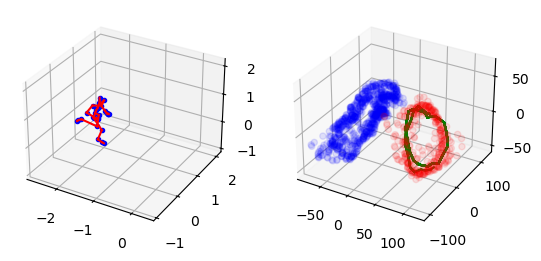

In [9]:
# animate the movement of the latent states using matplotlib

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X0[:, 0], X0[:, 1], X0[:, 2], c='blue', label='Walk', alpha=0.1)
ax2.scatter(X1[:, 0], X1[:, 1], X1[:, 2], c='red', label='Run', alpha=0.1)

def update(frame):
    ax1.clear()
    test_trial._joints["root"].set_motion(test_trial._frames[frame * DOWNSAMPLE])  
    test_trial._joints["root"].draw(ax=ax1, show=False)
    ax2.plot(predicted_latent_states[:frame, 0], predicted_latent_states[:frame, 1], predicted_latent_states[:frame, 2], c='green', label='Predicted')


print(f"Animating {len(predicted_latent_states)} frames, gif should be {len(predicted_latent_states) / (120 / DOWNSAMPLE)} seconds long")

ani = FuncAnimation(fig, update, frames=len(predicted_latent_states), repeat=False, interval=1000/120 * DOWNSAMPLE)
ani.save('gpdm_pf_latent_states.gif', writer='imagemagick')